In [27]:
from hcmus.utils import data_utils, transform_utils

splits = data_utils.get_data_splits()

2025-07-10 10:14:45.443 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:148 - Page size is too large, only 3443 tasks available.
2025-07-10 10:14:45.443 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:152 - New `page_to` applied: 35
Loading tasks: 100%|██████████| 35/35 [00:09<00:00,  3.51it/s]
2025-07-10 10:15:01.375 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:148 - Page size is too large, only 418 tasks available.
2025-07-10 10:15:01.376 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:152 - New `page_to` applied: 5
Loading tasks: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]
2025-07-10 10:15:06.684 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:148 - Page size is too large, only 286 tasks available.
2025-07-10 10:15:06.684 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:152 - New `page_to` applied: 3
Loading tasks: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


In [28]:
import random
from torchvision import transforms as T

def get_transforms(size: int = 128):
    transform_train = T.Compose([
        T.Lambda(lambda img: T.Resize(random.randint(32, 224))(img)),
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(180),
        T.ColorJitter(
            brightness=0.1,
            contrast=0.05,
            saturation=0.05,
            hue=0.0
        ),
        T.RandomResizedCrop(
            size=224,
            scale=(0.8, 1.2),
            ratio=(0.75, 1.3333)
        ),
        T.RandAugment(num_ops=5),
        T.ToTensor()
    ])

    transform_test = T.Compose([
        T.Resize((size, size)),
        T.Resize((224, 224)),
        T.ToTensor()
    ])

    return transform_train, transform_test

In [29]:
transform_train, transform_test = get_transforms()
datasets = data_utils.get_image_datasets_v2(splits, transform_train, transform_test, random_margin=0.2)
dataloaders = data_utils.get_data_loaders_v2(datasets, {
    "train": True
})

2025-07-10 10:15:09.275 | INFO     | hcmus.data._torch_dataset_v2:__init__:56 - Apply random_margin=0.2
2025-07-10 10:15:09.467 | INFO     | hcmus.data._torch_dataset_v2:__init__:67 - Auto infer `label2idx` mapping, mapping length: 99.
2025-07-10 10:15:09.472 | INFO     | hcmus.data._torch_dataset_v2:__init__:56 - Apply random_margin=0
2025-07-10 10:15:09.665 | INFO     | hcmus.data._torch_dataset_v2:__init__:56 - Apply random_margin=0


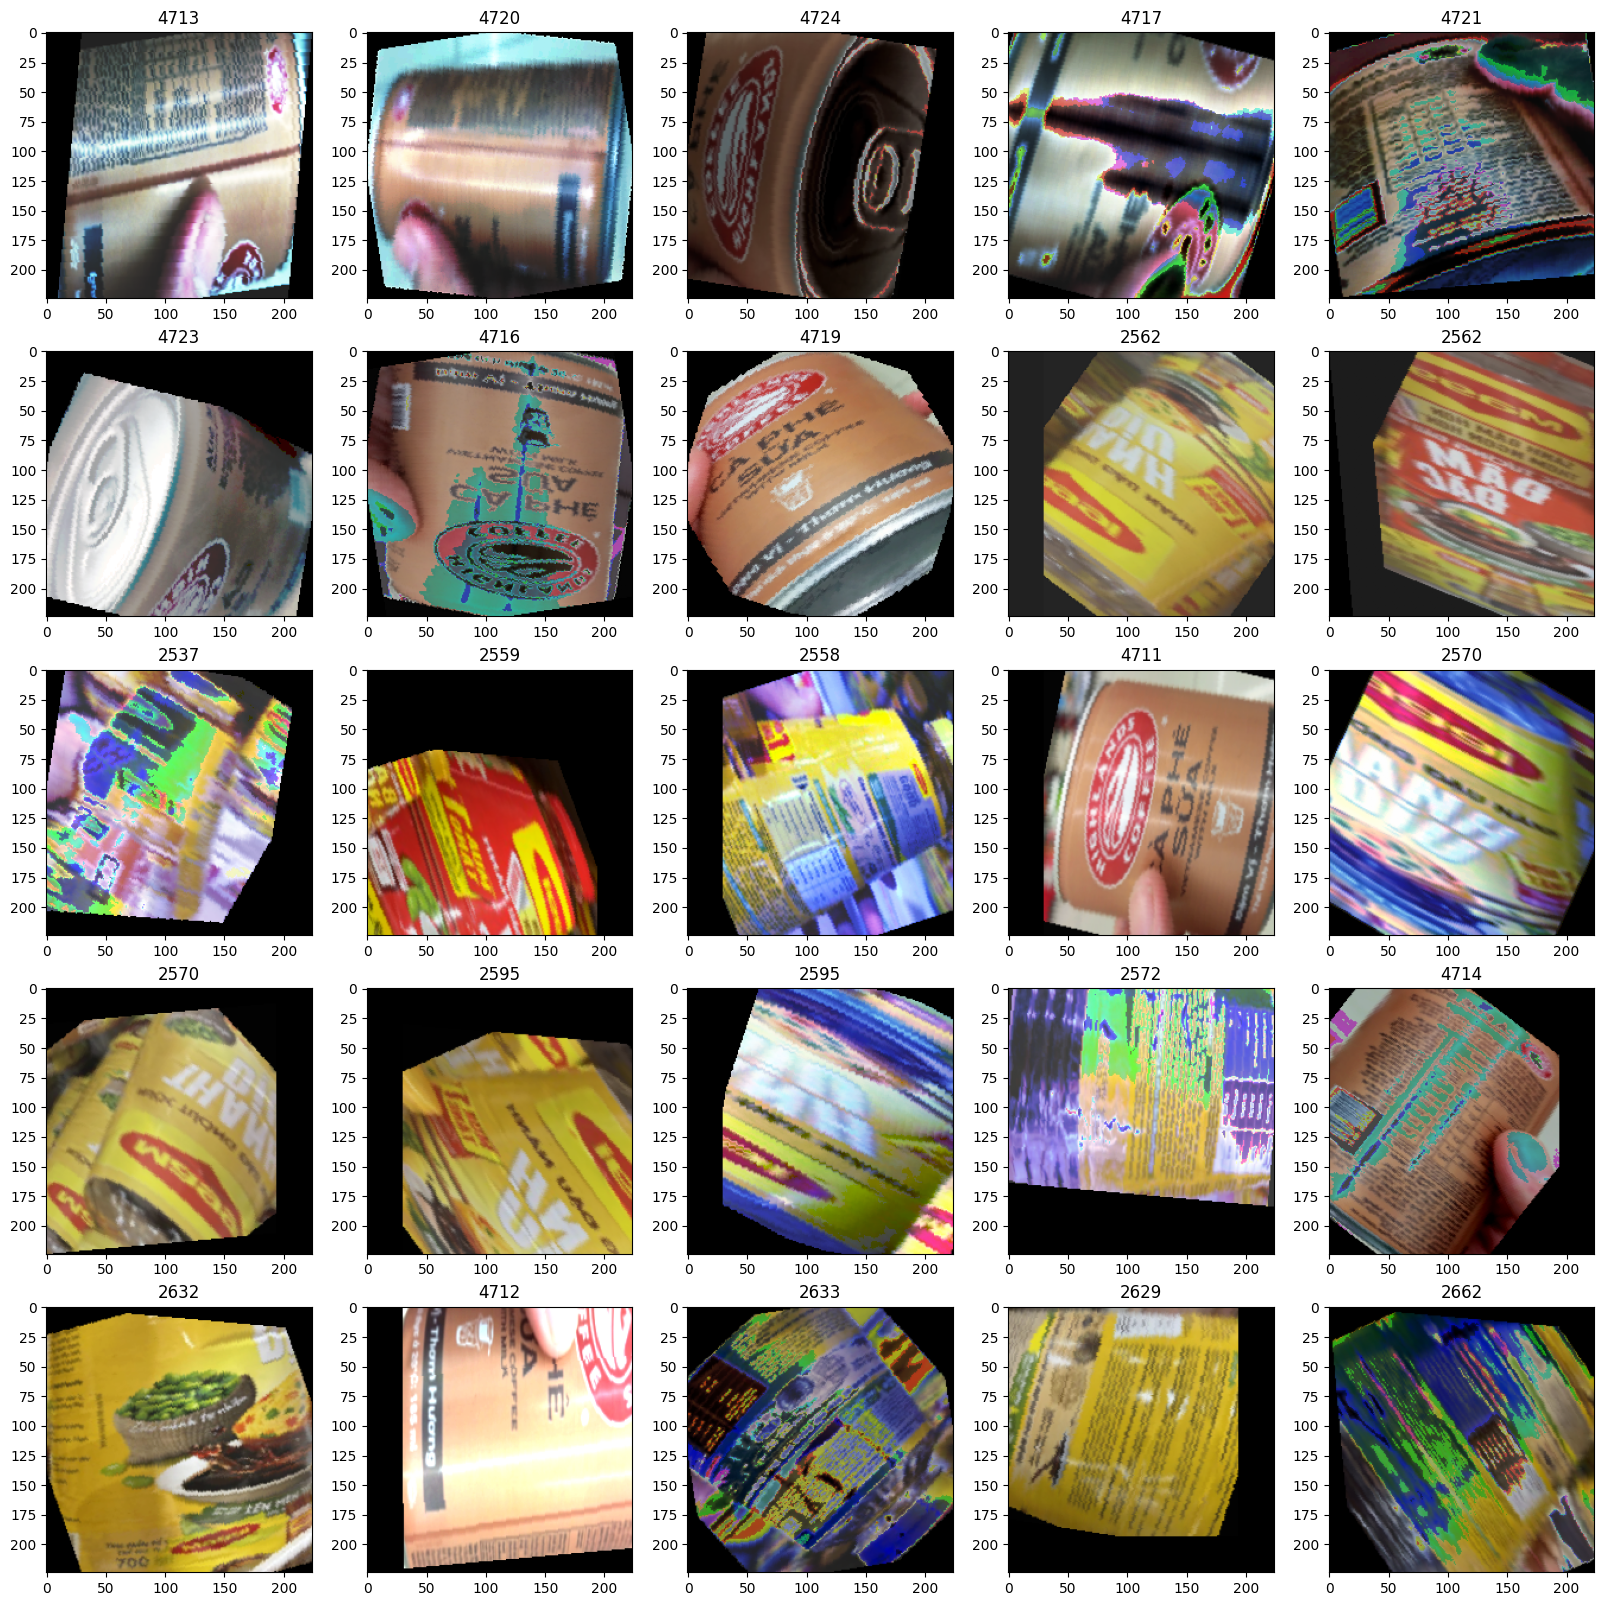

In [30]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
idx = 0
for x in range(5):
    for y in range(5):
        plt.subplot(5, 5, idx + 1)
        image, _, task = datasets["train"][idx]
        image = image.detach().numpy().transpose(1, 2, 0)
        plt.imshow(image)
        plt.title(task.get("task_id"))
        idx += 1

In [31]:
from hcmus.models.backbone import CLIPBackbone
from hcmus.models.backbone import DinoBackbone
from hcmus.models.transfer import TransferNetwork
from hcmus.models.transfer import TransferTrainer

In [32]:
backbone_list = [
    (DinoBackbone, {"model_id": "facebook/dinov2-small"}),
    # (DinoBackbone, {"model_id": "facebook/dinov2-base"}),
    # (DinoBackbone, {"model_id": "facebook/dino-vitb8"}),
    # (DinoBackbone, {"model_id": "facebook/dino-vits8"}),
    (DinoBackbone, {"model_id": "facebook/dino-vits16"}),
    # (DinoBackbone, {"model_id": "facebook/dino-vitb16"}),
    (CLIPBackbone, {"backbone_name": "ViT-B/32"}),
    (CLIPBackbone, {"backbone_name": "ViT-B/16"}),
]

In [33]:
import mlflow
def get_or_create_experiment():
    name = "/TransferLearning"
    try:
        mlflow.create_experiment(name)
    except:
        pass

    return mlflow.get_experiment_by_name(name).experiment_id

In [34]:
from hcmus.utils import mlflow_utils
get_or_create_experiment()
for cls, params in backbone_list:
    mlflow.end_run()
    backbone = cls(**params)
    model = TransferNetwork(backbone, output_dim=99)
    trainer = TransferTrainer(
        model=model,
        mlflow_experiment_name="/TransferLearning",
        mlflow_run_name=cls.__name__ + f"/{params}"
    )
    trainer.train(32, dataloaders["train"], dataloaders["val"])
    trainer.load_model("best_model.pt")
    trainer.evaluate(dataloaders["test"], log_mlflow=True)
    mlflow_utils.log_json_artifact(datasets["train"].label2idx, "label2idx.json")
    trainer.end_run()

🏃 View run DinoBackbone/{'model_id': 'facebook/dinov2-small'} at: http://jimica.ddns.net:5050/#/experiments/4/runs/22836e463de74126a3e364bcce38b7a6
🧪 View experiment at: http://jimica.ddns.net:5050/#/experiments/4


Epoch 1/32: 100%|██████████| 84/84 [01:35<00:00,  1.14s/it, Loss=2.2024]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 10:18:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 10:18:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/32:
  Train Loss: 3.8320
  Val Loss: 2.7620
  Val Accuracy: 0.2736
  Time: 215.94s
--------------------------------------------------


Epoch 2/32: 100%|██████████| 84/84 [01:33<00:00,  1.11s/it, Loss=1.0157]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 10:22:12 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 10:22:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 2/32:
  Train Loss: 2.1214
  Val Loss: 2.0203
  Val Accuracy: 0.4661
  Time: 206.85s
--------------------------------------------------


Epoch 3/32: 100%|██████████| 84/84 [01:35<00:00,  1.13s/it, Loss=0.7323]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 10:25:43 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 10:25:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 3/32:
  Train Loss: 1.4070
  Val Loss: 1.6691
  Val Accuracy: 0.5805
  Time: 211.82s
--------------------------------------------------


Epoch 4/32: 100%|██████████| 84/84 [01:36<00:00,  1.14s/it, Loss=1.5073]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/32:
  Train Loss: 1.1091
  Val Loss: 1.6058
  Val Accuracy: 0.5800
  Time: 207.94s
--------------------------------------------------


Epoch 5/32: 100%|██████████| 84/84 [01:39<00:00,  1.19s/it, Loss=0.0904]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 10:32:48 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 10:32:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 5/32:
  Train Loss: 0.9967
  Val Loss: 1.5143
  Val Accuracy: 0.6333
  Time: 217.72s
--------------------------------------------------


Epoch 6/32: 100%|██████████| 84/84 [01:39<00:00,  1.18s/it, Loss=0.2145]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/32:
  Train Loss: 0.8793
  Val Loss: 1.5918
  Val Accuracy: 0.6328
  Time: 204.12s
--------------------------------------------------


Epoch 7/32: 100%|██████████| 84/84 [01:32<00:00,  1.10s/it, Loss=1.4665]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 10:39:39 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 10:39:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 7/32:
  Train Loss: 0.7995
  Val Loss: 1.5559
  Val Accuracy: 0.6495
  Time: 206.14s
--------------------------------------------------


Epoch 8/32: 100%|██████████| 84/84 [01:32<00:00,  1.10s/it, Loss=0.0369]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/32:
  Train Loss: 0.7539
  Val Loss: 1.5209
  Val Accuracy: 0.6495
  Time: 194.50s
--------------------------------------------------


Epoch 9/32: 100%|██████████| 84/84 [01:32<00:00,  1.10s/it, Loss=0.2805]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/32:
  Train Loss: 0.6877
  Val Loss: 1.5504
  Val Accuracy: 0.6304
  Time: 195.06s
--------------------------------------------------


Epoch 10/32: 100%|██████████| 84/84 [01:32<00:00,  1.10s/it, Loss=0.3934]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/32:
  Train Loss: 0.6906
  Val Loss: 1.5818
  Val Accuracy: 0.6195
  Time: 195.38s
--------------------------------------------------


Epoch 11/32: 100%|██████████| 84/84 [01:32<00:00,  1.10s/it, Loss=0.6209]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 10:52:49 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 10:52:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 11/32:
  Train Loss: 0.6151
  Val Loss: 1.4570
  Val Accuracy: 0.6561
  Time: 204.83s
--------------------------------------------------


Epoch 12/32: 100%|██████████| 84/84 [01:31<00:00,  1.09s/it, Loss=0.0534]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/32:
  Train Loss: 0.6509
  Val Loss: 1.6510
  Val Accuracy: 0.6166
  Time: 194.65s
--------------------------------------------------


Epoch 13/32: 100%|██████████| 84/84 [01:33<00:00,  1.12s/it, Loss=0.0109]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/32:
  Train Loss: 0.5672
  Val Loss: 1.6817
  Val Accuracy: 0.6258
  Time: 197.83s
--------------------------------------------------


Epoch 14/32: 100%|██████████| 84/84 [01:33<00:00,  1.12s/it, Loss=0.0226]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/32:
  Train Loss: 0.5749
  Val Loss: 1.5830
  Val Accuracy: 0.6524
  Time: 198.19s
--------------------------------------------------


Epoch 15/32: 100%|██████████| 84/84 [01:34<00:00,  1.12s/it, Loss=1.8796]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/32:
  Train Loss: 0.5530
  Val Loss: 1.6768
  Val Accuracy: 0.6462
  Time: 198.05s
--------------------------------------------------


Epoch 16/32: 100%|██████████| 84/84 [01:32<00:00,  1.10s/it, Loss=0.0921]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 11:09:23 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 11:09:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 16/32:
  Train Loss: 0.6453
  Val Loss: 1.5376
  Val Accuracy: 0.6694
  Time: 205.38s
--------------------------------------------------


Epoch 17/32: 100%|██████████| 84/84 [01:32<00:00,  1.10s/it, Loss=0.7952]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/32:
  Train Loss: 0.5436
  Val Loss: 1.7887
  Val Accuracy: 0.6362
  Time: 193.18s
--------------------------------------------------


Epoch 18/32: 100%|██████████| 84/84 [01:31<00:00,  1.09s/it, Loss=0.1261]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 11:16:01 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 11:16:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 18/32:
  Train Loss: 0.5083
  Val Loss: 1.6034
  Val Accuracy: 0.6748
  Time: 204.83s
--------------------------------------------------


Epoch 19/32: 100%|██████████| 84/84 [01:34<00:00,  1.12s/it, Loss=0.2993]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/32:
  Train Loss: 0.5435
  Val Loss: 1.6242
  Val Accuracy: 0.6565
  Time: 196.11s
--------------------------------------------------


Epoch 20/32: 100%|██████████| 84/84 [01:32<00:00,  1.10s/it, Loss=0.6879]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/32:
  Train Loss: 0.4957
  Val Loss: 1.6310
  Val Accuracy: 0.6520
  Time: 194.84s
--------------------------------------------------


Epoch 21/32: 100%|██████████| 84/84 [01:31<00:00,  1.09s/it, Loss=0.2288]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21/32:
  Train Loss: 0.5298
  Val Loss: 1.5419
  Val Accuracy: 0.6728
  Time: 193.51s
--------------------------------------------------


Epoch 22/32: 100%|██████████| 84/84 [01:31<00:00,  1.09s/it, Loss=0.0440]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 11:29:10 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 11:29:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 22/32:
  Train Loss: 0.4666
  Val Loss: 1.6046
  Val Accuracy: 0.6832
  Time: 204.64s
--------------------------------------------------


Epoch 23/32: 100%|██████████| 84/84 [01:31<00:00,  1.09s/it, Loss=0.4439]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/32:
  Train Loss: 0.4915
  Val Loss: 1.5829
  Val Accuracy: 0.6620
  Time: 193.85s
--------------------------------------------------


Epoch 24/32: 100%|██████████| 84/84 [01:31<00:00,  1.09s/it, Loss=0.1029]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24/32:
  Train Loss: 0.4771
  Val Loss: 1.5851
  Val Accuracy: 0.6815
  Time: 193.56s
--------------------------------------------------


Epoch 25/32: 100%|██████████| 84/84 [01:31<00:00,  1.09s/it, Loss=0.0732]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/32:
  Train Loss: 0.4579
  Val Loss: 1.6940
  Val Accuracy: 0.6773
  Time: 193.57s
--------------------------------------------------


Epoch 26/32: 100%|██████████| 84/84 [01:30<00:00,  1.07s/it, Loss=0.1603]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 11:42:14 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 11:42:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 26/32:
  Train Loss: 0.4338
  Val Loss: 1.5600
  Val Accuracy: 0.6936
  Time: 202.77s
--------------------------------------------------


Epoch 27/32: 100%|██████████| 84/84 [01:30<00:00,  1.08s/it, Loss=0.0240]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/32:
  Train Loss: 0.3999
  Val Loss: 1.7360
  Val Accuracy: 0.6794
  Time: 191.91s
--------------------------------------------------


Epoch 28/32: 100%|██████████| 84/84 [01:30<00:00,  1.07s/it, Loss=0.2572]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/32:
  Train Loss: 0.4071
  Val Loss: 1.7001
  Val Accuracy: 0.6603
  Time: 191.53s
--------------------------------------------------


Epoch 29/32: 100%|██████████| 84/84 [01:28<00:00,  1.06s/it, Loss=0.2865]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29/32:
  Train Loss: 0.4292
  Val Loss: 1.6751
  Val Accuracy: 0.6761
  Time: 188.78s
--------------------------------------------------


Epoch 30/32: 100%|██████████| 84/84 [01:28<00:00,  1.06s/it, Loss=1.2937]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/32:
  Train Loss: 0.4753
  Val Loss: 1.8346
  Val Accuracy: 0.6495
  Time: 191.53s
--------------------------------------------------


Epoch 31/32: 100%|██████████| 84/84 [01:31<00:00,  1.09s/it, Loss=0.0355]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31/32:
  Train Loss: 0.4288
  Val Loss: 1.7495
  Val Accuracy: 0.6890
  Time: 192.68s
--------------------------------------------------


Epoch 32/32: 100%|██████████| 84/84 [01:30<00:00,  1.08s/it, Loss=0.0796]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 32/32:
  Train Loss: 0.4136
  Val Loss: 1.7595
  Val Accuracy: 0.6915
  Time: 191.87s
--------------------------------------------------


2025/07/10 12:01:33 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:01:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model loaded from best_model.pt


Evaluating: 100%|██████████| 187/187 [04:29<00:00,  1.44s/it]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EVALUATION RESULTS
Loss: 1.7148
Accuracy: 0.6384

Micro Averages:
  Precision: 0.6384
  Recall: 0.6384
  F1-Score: 0.6384

Macro Averages:
  Precision: 0.6389
  Recall: 0.5986
  F1-Score: 0.5495
🏃 View run DinoBackbone/{'model_id': 'facebook/dinov2-small'} at: http://jimica.ddns.net:5050/#/experiments/4/runs/18323656ae484da28f3b79e04152a9a0
🧪 View experiment at: http://jimica.ddns.net:5050/#/experiments/4


Epoch 1/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=3.1454]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 12:09:00 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:09:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/32:
  Train Loss: 3.9839
  Val Loss: 2.8551
  Val Accuracy: 0.3301
  Time: 175.21s
--------------------------------------------------


Epoch 2/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.7280]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 12:11:56 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:11:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 2/32:
  Train Loss: 1.8223
  Val Loss: 2.0594
  Val Accuracy: 0.4790
  Time: 175.90s
--------------------------------------------------


Epoch 3/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.5664]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 12:14:51 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:14:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 3/32:
  Train Loss: 1.0702
  Val Loss: 1.7341
  Val Accuracy: 0.5817
  Time: 175.39s
--------------------------------------------------


Epoch 4/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.3781]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 12:17:46 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:17:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 4/32:
  Train Loss: 0.8244
  Val Loss: 1.5298
  Val Accuracy: 0.6432
  Time: 175.31s
--------------------------------------------------


Epoch 5/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.4221]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 12:20:41 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:20:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 5/32:
  Train Loss: 0.7658
  Val Loss: 1.4860
  Val Accuracy: 0.6620
  Time: 175.03s
--------------------------------------------------


Epoch 6/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=1.2467]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/32:
  Train Loss: 0.6775
  Val Loss: 1.4532
  Val Accuracy: 0.6341
  Time: 164.20s
--------------------------------------------------


Epoch 7/32: 100%|██████████| 84/84 [01:15<00:00,  1.12it/s, Loss=0.5582]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 12:26:20 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:26:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 7/32:
  Train Loss: 0.5478
  Val Loss: 1.6184
  Val Accuracy: 0.6732
  Time: 174.40s
--------------------------------------------------


Epoch 8/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.1804]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/32:
  Train Loss: 0.5389
  Val Loss: 1.4844
  Val Accuracy: 0.6694
  Time: 163.96s
--------------------------------------------------


Epoch 9/32: 100%|██████████| 84/84 [01:15<00:00,  1.12it/s, Loss=0.0188]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 12:31:58 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:31:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 9/32:
  Train Loss: 0.4941
  Val Loss: 1.4291
  Val Accuracy: 0.6819
  Time: 174.46s
--------------------------------------------------


Epoch 10/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.1082]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/32:
  Train Loss: 0.4583
  Val Loss: 1.4236
  Val Accuracy: 0.6719
  Time: 164.10s
--------------------------------------------------


Epoch 11/32: 100%|██████████| 84/84 [01:15<00:00,  1.12it/s, Loss=0.6992]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 12:37:37 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:37:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 11/32:
  Train Loss: 0.4405
  Val Loss: 1.4274
  Val Accuracy: 0.6936
  Time: 174.50s
--------------------------------------------------


Epoch 12/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.4374]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/32:
  Train Loss: 0.4457
  Val Loss: 1.6334
  Val Accuracy: 0.6624
  Time: 164.42s
--------------------------------------------------


Epoch 13/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.0082]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 12:43:16 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:43:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 13/32:
  Train Loss: 0.4168
  Val Loss: 1.5219
  Val Accuracy: 0.7056
  Time: 174.58s
--------------------------------------------------


Epoch 14/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.0314]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 12:46:11 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 12:46:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 14/32:
  Train Loss: 0.3727
  Val Loss: 1.3669
  Val Accuracy: 0.7214
  Time: 174.74s
--------------------------------------------------


Epoch 15/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.8519]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/32:
  Train Loss: 0.3511
  Val Loss: 1.4563
  Val Accuracy: 0.7098
  Time: 164.29s
--------------------------------------------------


Epoch 16/32: 100%|██████████| 84/84 [01:15<00:00,  1.12it/s, Loss=0.0069]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/32:
  Train Loss: 0.4243
  Val Loss: 1.4992
  Val Accuracy: 0.7173
  Time: 163.98s
--------------------------------------------------


Epoch 17/32: 100%|██████████| 84/84 [01:15<00:00,  1.12it/s, Loss=1.7447]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/32:
  Train Loss: 0.3590
  Val Loss: 1.5161
  Val Accuracy: 0.7210
  Time: 163.84s
--------------------------------------------------


Epoch 18/32: 100%|██████████| 84/84 [01:15<00:00,  1.12it/s, Loss=0.1824]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/32:
  Train Loss: 0.4101
  Val Loss: 1.5896
  Val Accuracy: 0.7168
  Time: 163.79s
--------------------------------------------------


Epoch 19/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.0044]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/32:
  Train Loss: 0.4021
  Val Loss: 1.6180
  Val Accuracy: 0.7098
  Time: 163.97s
--------------------------------------------------


Epoch 20/32: 100%|██████████| 84/84 [01:15<00:00,  1.12it/s, Loss=0.0291]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 13:02:45 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 13:02:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 20/32:
  Train Loss: 0.3289
  Val Loss: 1.4637
  Val Accuracy: 0.7393
  Time: 174.63s
--------------------------------------------------


Epoch 21/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.0452]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21/32:
  Train Loss: 0.3137
  Val Loss: 1.6960
  Val Accuracy: 0.7114
  Time: 164.20s
--------------------------------------------------


Epoch 22/32: 100%|██████████| 84/84 [01:15<00:00,  1.12it/s, Loss=0.0027]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/32:
  Train Loss: 0.2929
  Val Loss: 1.8024
  Val Accuracy: 0.6915
  Time: 163.93s
--------------------------------------------------


Epoch 23/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.0314]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/32:
  Train Loss: 0.3408
  Val Loss: 1.6939
  Val Accuracy: 0.7060
  Time: 164.50s
--------------------------------------------------


Epoch 24/32: 100%|██████████| 84/84 [01:15<00:00,  1.12it/s, Loss=0.0310]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24/32:
  Train Loss: 0.2792
  Val Loss: 1.7932
  Val Accuracy: 0.6911
  Time: 164.03s
--------------------------------------------------


Epoch 25/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.7223]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/32:
  Train Loss: 0.3328
  Val Loss: 1.5562
  Val Accuracy: 0.7164
  Time: 164.14s
--------------------------------------------------


Epoch 26/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.0005]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/32:
  Train Loss: 0.3630
  Val Loss: 1.6606
  Val Accuracy: 0.7048
  Time: 164.14s
--------------------------------------------------


Epoch 27/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.0002]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/32:
  Train Loss: 0.3138
  Val Loss: 1.6745
  Val Accuracy: 0.7035
  Time: 164.36s
--------------------------------------------------


Epoch 28/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=0.0096]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/32:
  Train Loss: 0.3258
  Val Loss: 1.6308
  Val Accuracy: 0.7260
  Time: 167.01s
--------------------------------------------------


Epoch 29/32: 100%|██████████| 84/84 [01:18<00:00,  1.08it/s, Loss=0.7652]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29/32:
  Train Loss: 0.3215
  Val Loss: 1.5246
  Val Accuracy: 0.7339
  Time: 172.18s
--------------------------------------------------


Epoch 30/32: 100%|██████████| 84/84 [01:16<00:00,  1.10it/s, Loss=0.1263]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/32:
  Train Loss: 0.3119
  Val Loss: 1.7140
  Val Accuracy: 0.7193
  Time: 164.52s
--------------------------------------------------


Epoch 31/32: 100%|██████████| 84/84 [01:15<00:00,  1.11it/s, Loss=3.6418]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31/32:
  Train Loss: 0.3285
  Val Loss: 1.8592
  Val Accuracy: 0.6657
  Time: 165.01s
--------------------------------------------------


Epoch 32/32: 100%|██████████| 84/84 [01:16<00:00,  1.10it/s, Loss=0.0531]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 32/32:
  Train Loss: 0.3452
  Val Loss: 1.8622
  Val Accuracy: 0.6952
  Time: 165.53s
--------------------------------------------------


2025/07/10 13:36:00 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 13:36:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model loaded from best_model.pt


Evaluating: 100%|██████████| 187/187 [03:55<00:00,  1.26s/it]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EVALUATION RESULTS
Loss: 1.7208
Accuracy: 0.6924

Micro Averages:
  Precision: 0.6924
  Recall: 0.6924
  F1-Score: 0.6924

Macro Averages:
  Precision: 0.6814
  Recall: 0.6563
  F1-Score: 0.6167
🏃 View run DinoBackbone/{'model_id': 'facebook/dino-vits16'} at: http://jimica.ddns.net:5050/#/experiments/4/runs/0ed0546cc6c5416780b08fc899f725b3
🧪 View experiment at: http://jimica.ddns.net:5050/#/experiments/4


Epoch 1/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=4.8921]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 13:42:27 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 13:42:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/32:
  Train Loss: 4.4753
  Val Loss: 4.2650
  Val Accuracy: 0.0886
  Time: 177.41s
--------------------------------------------------


Epoch 2/32: 100%|██████████| 84/84 [01:03<00:00,  1.32it/s, Loss=3.5883]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 13:45:27 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 13:45:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 2/32:
  Train Loss: 3.8502
  Val Loss: 3.2623
  Val Accuracy: 0.2865
  Time: 161.39s
--------------------------------------------------


Epoch 3/32: 100%|██████████| 84/84 [01:02<00:00,  1.34it/s, Loss=1.9019]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 13:48:07 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 13:48:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 3/32:
  Train Loss: 2.9553
  Val Loss: 2.3669
  Val Accuracy: 0.4374
  Time: 160.14s
--------------------------------------------------


Epoch 4/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=2.0102]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 13:50:46 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 13:50:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 4/32:
  Train Loss: 2.3255
  Val Loss: 1.8749
  Val Accuracy: 0.5110
  Time: 159.62s
--------------------------------------------------


Epoch 5/32: 100%|██████████| 84/84 [01:02<00:00,  1.34it/s, Loss=1.6314]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 13:53:30 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 13:53:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 5/32:
  Train Loss: 1.8772
  Val Loss: 1.6257
  Val Accuracy: 0.5917
  Time: 163.28s
--------------------------------------------------


Epoch 6/32: 100%|██████████| 84/84 [01:04<00:00,  1.29it/s, Loss=2.5877]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/32:
  Train Loss: 1.6918
  Val Loss: 1.4973
  Val Accuracy: 0.5879
  Time: 143.59s
--------------------------------------------------


Epoch 7/32: 100%|██████████| 84/84 [01:04<00:00,  1.31it/s, Loss=0.9956]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 13:58:37 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 13:58:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 7/32:
  Train Loss: 1.4875
  Val Loss: 1.4067
  Val Accuracy: 0.6220
  Time: 173.86s
--------------------------------------------------


Epoch 8/32: 100%|██████████| 84/84 [01:03<00:00,  1.33it/s, Loss=0.6645]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 14:01:28 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 14:01:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 8/32:
  Train Loss: 1.3933
  Val Loss: 1.2773
  Val Accuracy: 0.6644
  Time: 159.94s
--------------------------------------------------


Epoch 9/32: 100%|██████████| 84/84 [01:02<00:00,  1.34it/s, Loss=0.3642]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/32:
  Train Loss: 1.2774
  Val Loss: 1.3026
  Val Accuracy: 0.6462
  Time: 139.07s
--------------------------------------------------


Epoch 10/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.4645]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/32:
  Train Loss: 1.2251
  Val Loss: 1.3644
  Val Accuracy: 0.6254
  Time: 138.83s
--------------------------------------------------


Epoch 11/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.3518]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 14:08:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 14:08:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 11/32:
  Train Loss: 1.1555
  Val Loss: 1.2082
  Val Accuracy: 0.6682
  Time: 158.67s
--------------------------------------------------


Epoch 12/32: 100%|██████████| 84/84 [01:02<00:00,  1.34it/s, Loss=0.7878]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/32:
  Train Loss: 1.1379
  Val Loss: 1.2364
  Val Accuracy: 0.6653
  Time: 139.26s
--------------------------------------------------


Epoch 13/32: 100%|██████████| 84/84 [01:02<00:00,  1.34it/s, Loss=0.5356]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 14:13:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 14:13:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 13/32:
  Train Loss: 1.0722
  Val Loss: 1.1200
  Val Accuracy: 0.6944
  Time: 160.53s
--------------------------------------------------


Epoch 14/32: 100%|██████████| 84/84 [01:03<00:00,  1.33it/s, Loss=0.7963]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 14:16:25 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 14:16:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 14/32:
  Train Loss: 1.0291
  Val Loss: 1.1339
  Val Accuracy: 0.7094
  Time: 160.97s
--------------------------------------------------


Epoch 15/32: 100%|██████████| 84/84 [01:03<00:00,  1.33it/s, Loss=0.9998]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/32:
  Train Loss: 0.9560
  Val Loss: 1.0920
  Val Accuracy: 0.7048
  Time: 140.80s
--------------------------------------------------


Epoch 16/32: 100%|██████████| 84/84 [01:03<00:00,  1.33it/s, Loss=0.7681]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/32:
  Train Loss: 1.0218
  Val Loss: 1.1319
  Val Accuracy: 0.7048
  Time: 140.69s
--------------------------------------------------


Epoch 17/32: 100%|██████████| 84/84 [01:02<00:00,  1.33it/s, Loss=0.5877]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/32:
  Train Loss: 1.0197
  Val Loss: 1.0827
  Val Accuracy: 0.7089
  Time: 139.17s
--------------------------------------------------


Epoch 18/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.4317]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 14:26:04 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 14:26:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 18/32:
  Train Loss: 0.9574
  Val Loss: 1.0647
  Val Accuracy: 0.7177
  Time: 160.64s
--------------------------------------------------


Epoch 19/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.1067]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/32:
  Train Loss: 0.9016
  Val Loss: 1.0992
  Val Accuracy: 0.6936
  Time: 138.50s
--------------------------------------------------


Epoch 20/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=2.6241]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 14:31:03 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 14:31:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 20/32:
  Train Loss: 0.8920
  Val Loss: 1.0933
  Val Accuracy: 0.7193
  Time: 158.66s
--------------------------------------------------


Epoch 21/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=2.1817]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 14:33:42 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 14:33:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 21/32:
  Train Loss: 0.9084
  Val Loss: 1.0270
  Val Accuracy: 0.7272
  Time: 158.57s
--------------------------------------------------


Epoch 22/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.8464]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/32:
  Train Loss: 0.9074
  Val Loss: 1.1172
  Val Accuracy: 0.7060
  Time: 138.63s
--------------------------------------------------


Epoch 23/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.5768]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/32:
  Train Loss: 0.8609
  Val Loss: 1.0887
  Val Accuracy: 0.7173
  Time: 138.33s
--------------------------------------------------


Epoch 24/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.1951]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 14:40:58 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 14:40:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 24/32:
  Train Loss: 0.7964
  Val Loss: 1.0449
  Val Accuracy: 0.7351
  Time: 159.34s
--------------------------------------------------


Epoch 25/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.4369]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/32:
  Train Loss: 0.8297
  Val Loss: 1.0702
  Val Accuracy: 0.7264
  Time: 138.75s
--------------------------------------------------


Epoch 26/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.9273]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/32:
  Train Loss: 0.8348
  Val Loss: 1.1005
  Val Accuracy: 0.7164
  Time: 138.52s
--------------------------------------------------


Epoch 27/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.4685]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/32:
  Train Loss: 0.8282
  Val Loss: 1.0166
  Val Accuracy: 0.7314
  Time: 138.49s
--------------------------------------------------


Epoch 28/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.1934]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/32:
  Train Loss: 0.8058
  Val Loss: 1.0395
  Val Accuracy: 0.7235
  Time: 138.34s
--------------------------------------------------


Epoch 29/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.0313]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 14:52:51 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 14:52:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 29/32:
  Train Loss: 0.7959
  Val Loss: 0.9916
  Val Accuracy: 0.7426
  Time: 158.87s
--------------------------------------------------


Epoch 30/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.8278]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/32:
  Train Loss: 0.7567
  Val Loss: 1.1019
  Val Accuracy: 0.7247
  Time: 138.45s
--------------------------------------------------


Epoch 31/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.0301]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31/32:
  Train Loss: 0.7609
  Val Loss: 1.0847
  Val Accuracy: 0.7252
  Time: 138.49s
--------------------------------------------------


Epoch 32/32: 100%|██████████| 84/84 [01:02<00:00,  1.35it/s, Loss=0.7667]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 32/32:
  Train Loss: 0.7367
  Val Loss: 1.0398
  Val Accuracy: 0.7351
  Time: 141.53s
--------------------------------------------------


2025/07/10 15:00:10 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 15:00:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model loaded from best_model.pt


Evaluating: 100%|██████████| 187/187 [03:27<00:00,  1.11s/it]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EVALUATION RESULTS
Loss: 1.0565
Accuracy: 0.7428

Micro Averages:
  Precision: 0.7428
  Recall: 0.7428
  F1-Score: 0.7428

Macro Averages:
  Precision: 0.7026
  Recall: 0.7295
  F1-Score: 0.6730
🏃 View run CLIPBackbone/{'backbone_name': 'ViT-B/32'} at: http://jimica.ddns.net:5050/#/experiments/4/runs/4afad15f70a94db18c50d4e52db1ae3e
🧪 View experiment at: http://jimica.ddns.net:5050/#/experiments/4


Epoch 1/32: 100%|██████████| 84/84 [02:14<00:00,  1.60s/it, Loss=4.2925]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 15:08:36 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 15:08:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/32:
  Train Loss: 4.4809
  Val Loss: 4.1921
  Val Accuracy: 0.1002
  Time: 296.57s
--------------------------------------------------


Epoch 2/32: 100%|██████████| 84/84 [02:17<00:00,  1.64s/it, Loss=4.4098]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 15:13:37 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 15:13:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 2/32:
  Train Loss: 3.7779
  Val Loss: 3.0052
  Val Accuracy: 0.3247
  Time: 312.92s
--------------------------------------------------


Epoch 3/32: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it, Loss=1.7466]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 15:18:54 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 15:18:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 3/32:
  Train Loss: 2.8106
  Val Loss: 2.0482
  Val Accuracy: 0.5081
  Time: 318.01s
--------------------------------------------------


Epoch 4/32: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it, Loss=0.9322]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 15:24:11 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 15:24:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 4/32:
  Train Loss: 2.1666
  Val Loss: 1.6805
  Val Accuracy: 0.5609
  Time: 314.83s
--------------------------------------------------


Epoch 5/32: 100%|██████████| 84/84 [02:17<00:00,  1.64s/it, Loss=1.6765]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 15:29:22 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 15:29:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 5/32:
  Train Loss: 1.7738
  Val Loss: 1.3611
  Val Accuracy: 0.6337
  Time: 310.92s
--------------------------------------------------


Epoch 6/32: 100%|██████████| 84/84 [02:17<00:00,  1.64s/it, Loss=2.3778]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 15:34:33 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 15:34:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 6/32:
  Train Loss: 1.5278
  Val Loss: 1.2389
  Val Accuracy: 0.6740
  Time: 309.27s
--------------------------------------------------


Epoch 7/32: 100%|██████████| 84/84 [02:17<00:00,  1.64s/it, Loss=0.7904]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 15:39:42 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 15:39:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 7/32:
  Train Loss: 1.4209
  Val Loss: 1.0869
  Val Accuracy: 0.7152
  Time: 310.64s
--------------------------------------------------


Epoch 8/32: 100%|██████████| 84/84 [02:19<00:00,  1.67s/it, Loss=2.1540]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/32:
  Train Loss: 1.2830
  Val Loss: 1.0447
  Val Accuracy: 0.7143
  Time: 285.34s
--------------------------------------------------


Epoch 9/32: 100%|██████████| 84/84 [02:18<00:00,  1.65s/it, Loss=1.2864]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/32:
  Train Loss: 1.1957
  Val Loss: 1.0537
  Val Accuracy: 0.7131
  Time: 282.45s
--------------------------------------------------


Epoch 10/32: 100%|██████████| 84/84 [02:18<00:00,  1.65s/it, Loss=2.2139]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/32:
  Train Loss: 1.1178
  Val Loss: 1.0542
  Val Accuracy: 0.7002
  Time: 281.61s
--------------------------------------------------


Epoch 11/32: 100%|██████████| 84/84 [02:17<00:00,  1.64s/it, Loss=1.1544]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/32:
  Train Loss: 1.0251
  Val Loss: 1.0323
  Val Accuracy: 0.7044
  Time: 279.48s
--------------------------------------------------


Epoch 12/32: 100%|██████████| 84/84 [02:16<00:00,  1.62s/it, Loss=0.7647]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 16:03:41 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 16:03:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 12/32:
  Train Loss: 1.0285
  Val Loss: 0.9476
  Val Accuracy: 0.7364
  Time: 305.71s
--------------------------------------------------


Epoch 13/32: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it, Loss=2.1471]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/32:
  Train Loss: 1.0044
  Val Loss: 0.9385
  Val Accuracy: 0.7322
  Time: 279.78s
--------------------------------------------------


Epoch 14/32: 100%|██████████| 84/84 [02:14<00:00,  1.60s/it, Loss=0.5289]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 16:13:22 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 16:13:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 14/32:
  Train Loss: 0.9822
  Val Loss: 0.9032
  Val Accuracy: 0.7459
  Time: 302.50s
--------------------------------------------------


Epoch 15/32: 100%|██████████| 84/84 [02:14<00:00,  1.60s/it, Loss=0.4936]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 16:18:25 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 16:18:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 15/32:
  Train Loss: 0.9042
  Val Loss: 0.8907
  Val Accuracy: 0.7601
  Time: 310.36s
--------------------------------------------------


Epoch 16/32: 100%|██████████| 84/84 [02:14<00:00,  1.60s/it, Loss=0.6118]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/32:
  Train Loss: 0.8926
  Val Loss: 0.9082
  Val Accuracy: 0.7584
  Time: 275.35s
--------------------------------------------------


Epoch 17/32: 100%|██████████| 84/84 [02:16<00:00,  1.63s/it, Loss=0.7790]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/32:
  Train Loss: 0.8956
  Val Loss: 0.8968
  Val Accuracy: 0.7563
  Time: 277.79s
--------------------------------------------------


Epoch 18/32: 100%|██████████| 84/84 [02:16<00:00,  1.62s/it, Loss=1.0857]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/32:
  Train Loss: 0.8244
  Val Loss: 0.9687
  Val Accuracy: 0.7443
  Time: 279.14s
--------------------------------------------------


Epoch 19/32: 100%|██████████| 84/84 [02:17<00:00,  1.64s/it, Loss=0.0390]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/32:
  Train Loss: 0.8701
  Val Loss: 0.9511
  Val Accuracy: 0.7439
  Time: 281.51s
--------------------------------------------------


Epoch 20/32: 100%|██████████| 84/84 [02:17<00:00,  1.64s/it, Loss=1.2711]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 16:42:18 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 16:42:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 20/32:
  Train Loss: 0.8213
  Val Loss: 0.9022
  Val Accuracy: 0.7617
  Time: 326.06s
--------------------------------------------------


Epoch 21/32: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it, Loss=0.0325]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model saved to best_model.pt


2025/07/10 16:47:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 16:47:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 21/32:
  Train Loss: 0.8218
  Val Loss: 0.8794
  Val Accuracy: 0.7676
  Time: 316.75s
--------------------------------------------------


Epoch 22/32: 100%|██████████| 84/84 [02:18<00:00,  1.65s/it, Loss=1.1363]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/32:
  Train Loss: 0.7952
  Val Loss: 0.9373
  Val Accuracy: 0.7518
  Time: 282.54s
--------------------------------------------------


Epoch 23/32: 100%|██████████| 84/84 [02:21<00:00,  1.68s/it, Loss=0.6573]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/32:
  Train Loss: 0.7384
  Val Loss: 0.9366
  Val Accuracy: 0.7530
  Time: 283.61s
--------------------------------------------------


Epoch 24/32: 100%|██████████| 84/84 [02:16<00:00,  1.63s/it, Loss=0.5488]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24/32:
  Train Loss: 0.7788
  Val Loss: 0.9791
  Val Accuracy: 0.7389
  Time: 279.04s
--------------------------------------------------


Epoch 25/32: 100%|██████████| 84/84 [02:18<00:00,  1.64s/it, Loss=0.3116]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/32:
  Train Loss: 0.7378
  Val Loss: 1.0173
  Val Accuracy: 0.7356
  Time: 282.59s
--------------------------------------------------


Epoch 26/32: 100%|██████████| 84/84 [02:17<00:00,  1.64s/it, Loss=0.5179]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/32:
  Train Loss: 0.7390
  Val Loss: 0.9471
  Val Accuracy: 0.7435
  Time: 280.00s
--------------------------------------------------


Epoch 27/32: 100%|██████████| 84/84 [02:16<00:00,  1.63s/it, Loss=1.6714]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/32:
  Train Loss: 0.7140
  Val Loss: 1.0487
  Val Accuracy: 0.7231
  Time: 278.16s
--------------------------------------------------


Epoch 28/32: 100%|██████████| 84/84 [02:15<00:00,  1.62s/it, Loss=1.4222]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/32:
  Train Loss: 0.7355
  Val Loss: 1.0832
  Val Accuracy: 0.7227
  Time: 277.70s
--------------------------------------------------


Epoch 29/32: 100%|██████████| 84/84 [02:15<00:00,  1.61s/it, Loss=1.0325]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29/32:
  Train Loss: 0.7542
  Val Loss: 0.9689
  Val Accuracy: 0.7572
  Time: 276.07s
--------------------------------------------------


Epoch 30/32: 100%|██████████| 84/84 [02:15<00:00,  1.61s/it, Loss=0.2645]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/32:
  Train Loss: 0.7087
  Val Loss: 0.9888
  Val Accuracy: 0.7464
  Time: 275.32s
--------------------------------------------------


Epoch 31/32: 100%|██████████| 84/84 [02:15<00:00,  1.61s/it, Loss=2.7210]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31/32:
  Train Loss: 0.7351
  Val Loss: 0.9684
  Val Accuracy: 0.7426
  Time: 277.36s
--------------------------------------------------


Epoch 32/32: 100%|██████████| 84/84 [02:15<00:00,  1.61s/it, Loss=0.1325]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 32/32:
  Train Loss: 0.6790
  Val Loss: 0.9311
  Val Accuracy: 0.7480
  Time: 277.58s
--------------------------------------------------


2025/07/10 17:39:26 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2025-04-15; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'item-identification'}
2025/07/10 17:39:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model loaded from best_model.pt


Evaluating: 100%|██████████| 187/187 [06:12<00:00,  1.99s/it]
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EVALUATION RESULTS
Loss: 1.0206
Accuracy: 0.7386

Micro Averages:
  Precision: 0.7386
  Recall: 0.7386
  F1-Score: 0.7386

Macro Averages:
  Precision: 0.7047
  Recall: 0.7350
  F1-Score: 0.6731
🏃 View run CLIPBackbone/{'backbone_name': 'ViT-B/16'} at: http://jimica.ddns.net:5050/#/experiments/4/runs/0e5226a897a044ae9814031dbbedb014
🧪 View experiment at: http://jimica.ddns.net:5050/#/experiments/4
